# EdgeCameras.jl: Edge Cameras in Julia

This project consists of an implementation of *edge cameras* based on the work of Bouman et al. [1]. An edge camera is formed when a sharp edge (such as the corner of a wall) creates a natural one-dimensonal pinhole camera, revealing the motions of objects which are completely obscured by the corner. More information from the original authors can be found at [people.csail.mit.edu](https://people.csail.mit.edu/klbouman/cornercameras.html). 

This package consists of an entirely new implementation of the edge camera algorithm, based on the work presented in the paper, and done entirely in [Julia](https://julialang.org/) (except for the raw video I/O, which is ultimately handled by `ffmpeg`).

[1] Katherine L. Bouman, Vickie Ye, Gregory W. Wornell, Adam B. Yedidia, Antonio Torralba, William T. Freeman, and Frédo Durand. "Turning Corners into Cameras: Principles and Methods". ICCV 2017.

# Installation

In Julia:

```julia
Pkg.clone("https://github.com/rdeits/EdgeCameras.jl")
```

# Stereo Reconstruction

We can use two edge cameras (such as two of the edges around a doorway) to obtain two bearings to a moving object. This lets us, at least approximately, track the 2D position of the object on the other side of the doorway. 

In [24]:
using Plots: plot
using StaticArrays: SVector
using VideoIO: openvideo
using EdgeCameras: background, StaticSource, Params, EdgeCamera, reconstruct
using Images: imadjustintensity, RGB
using Unitful
using AxisArrays
using Interpolations

In [3]:
# Open a video file. This assumes that you've already downloaded the 
# example videos data from https://people.csail.mit.edu/klbouman/cornercameras.html
video = openvideo("example_videos/stereo/red_person_walking_circles.MP4")

VideoReader(...)

In [8]:
# Extract the background by taking the average of several frames. This 
# takes the mean over frames from 10 second to 20 seconds, using every 
# 10th frame. 
background_im = background(video, (10u"s", 20u"s"), 10);

In [9]:
# Pre-specify some parameters
time_range = (0u"s", 30u"s") # the time span over which to reconstruct video
reconstruction_framerate = 10/u"s" # the frame rate for reconstruction
λ = sqrt(2.7) # a noise parameter set empirically
params = Params(); # other parameters for the camera, set to their defaults

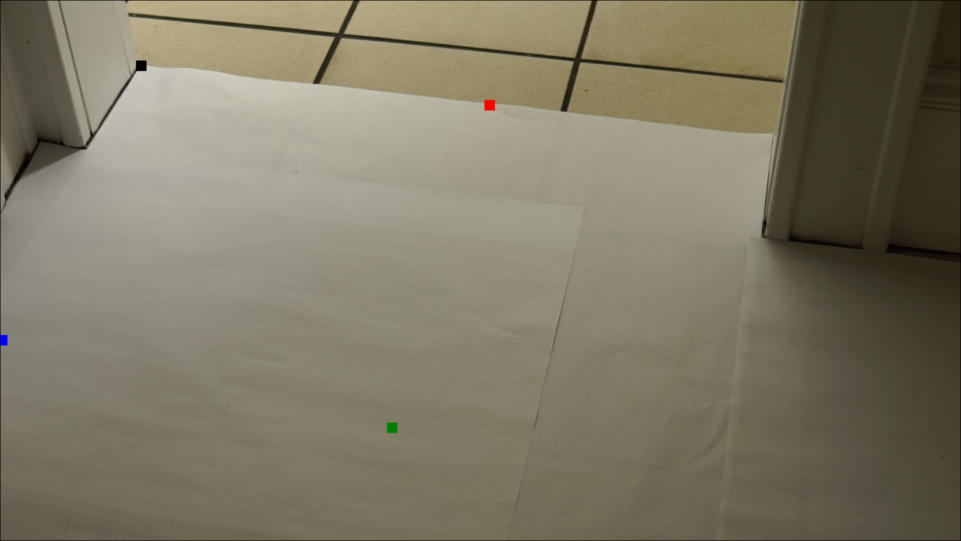

In [10]:
# Specify the corners of a square region around the edge of the wall you're 
# using as a camera. These are pixel coordinates, with the first point (black) 
# at the location of the bottom corner of the wall, and the remaining points
# arranged in the order shown by the red, green, and blue points
corners1 = [[131, 282], 
    [210, 979],
    [855, 784], 
    [680, 4], 
]
source1 = StaticSource(video, corners1, background_im, λ)

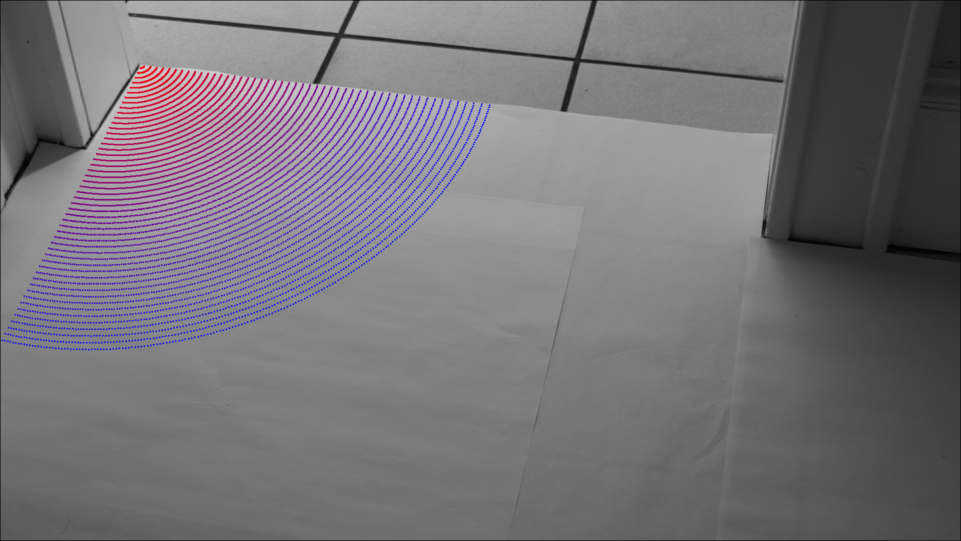

In [12]:
# cam1 corresponds to one of the edges on the left:
cam1 = EdgeCamera(source1, params)

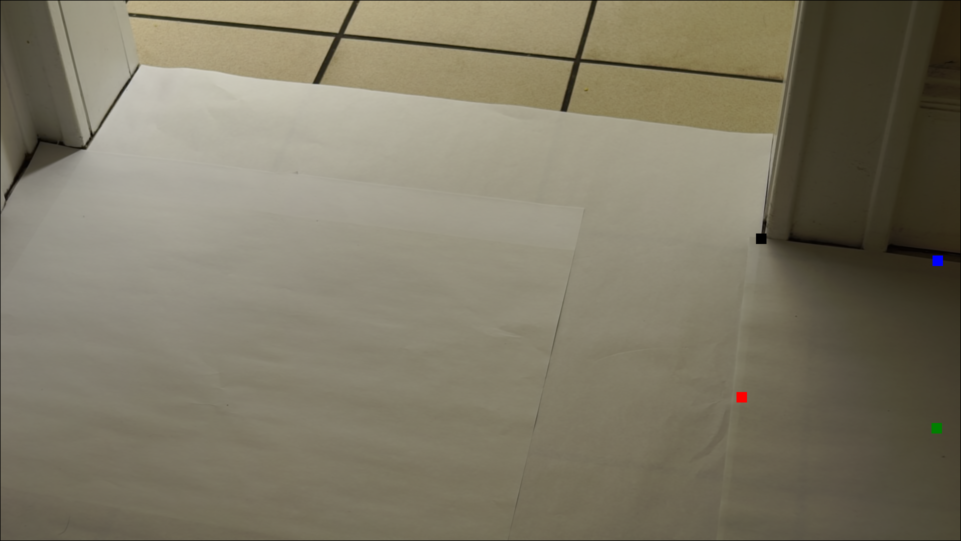

In [14]:
# Now specify the corders of the second edge camera, this one on the 
# right side of the doorway:
corners2 = [
    [477, 1522],
    [794, 1483],
    [856, 1873],
    [521, 1875]
]
source2 = StaticSource(video, corners2, background_im, λ)

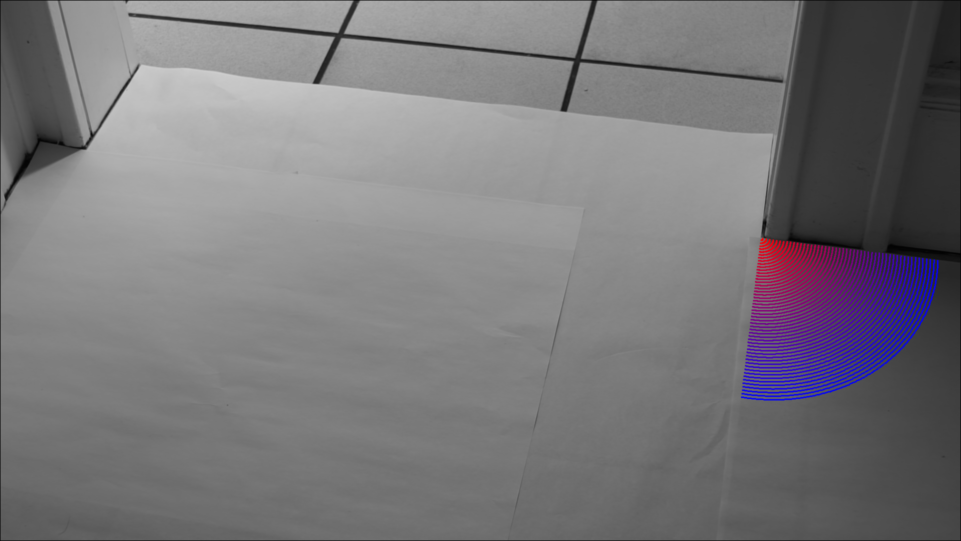

In [16]:
# Show where cam2 will draw samples
cam2 = EdgeCamera(source2, params)

In [17]:
# Now we will reconstruct the 1D video seen by each camera:

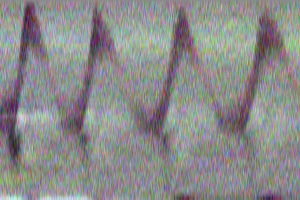

In [18]:
# Left side
trace1 = reconstruct(cam1, time_range, reconstruction_framerate)
imadjustintensity(trace1)

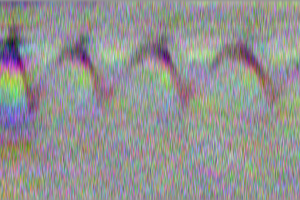

In [20]:
# Right side
trace2 = reconstruct(cam2, time_range, reconstruction_framerate)
imadjustintensity(trace2)

## Extracting 2D Position

To estimate the position of the person on the other side of the door, we need to first identify the center of the 1D video signal. Rather than writing code to do it automatically, we can just indicate a few points by hand and interpolate linearly:

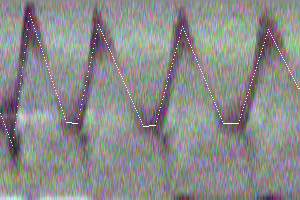

In [25]:
path1 = [
    [114, 1],
    [146, 13],
    [14, 30],
    [123, 67],
    [124, 78],
    [25, 99],
    [127, 144],
    [126, 156],
    [27, 183],
    [124, 224],
    [124, 239],
    [30, 269],
    [89, 299]
    ]

path1 = extrapolate(interpolate(
    (last.(path1),),
    first.(path1),
        Gridded(Linear())),
    Flat()
    );

# Show the extracted path on top of the trace
im = imadjustintensity(trace1)
for i in 1:size(trace1, 2)
    im[round(Int, path1[i]), i] = RGB(1., 1, 1)
end
im

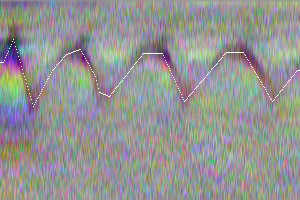

In [27]:
path2 = [
    [63, 4],
    [40, 14],
    [107, 34],
    [71, 53],
    [55, 67],
    [50, 81],
    [77, 96],
    [93, 100],
    [97, 110],
    [54, 144],
    [54, 163],
    [102, 185],
    [53, 227],
    [53, 244],
    [102, 273],
    [71, 298]
    ]

path2 = extrapolate(interpolate(
    (last.(path2),),
    first.(path2),
        Gridded(Linear())),
    Flat()
    );


im = imadjustintensity(trace2)
for i in 1:size(trace2, 2)
    im[round(Int, path2[i]), i] = RGB(1., 1., 1.)
end
im

In [28]:
# From the two angles extracted from the left and right
# cameras, we can estimate the position of the object
# in 2D space:
B = 1.0
positions = map(1:size(trace1, 2)) do i
    θ1 = π/2 * path1[i] / size(trace1, 1) - π/2
    θ2 = π/2 * path2[i] / size(trace2, 1)
    Pz = B / (cot(θ1) + cot(θ2))
    Px = Pz * cot(θ1)
    SVector(Px, Pz)
end;

In [29]:
plt = plot(first.(positions), 
           last.(positions), 
           linewidth=3, 
           color=1:length(positions),
           legend=false,
           xlabel="X-position",
           ylabel="Z-position",
           title="Inferred Position over Time (Scene B)")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 
 
 -2.5 
 
 
 -2.0 
 
 
 -1.5 
 
 
 -1.0 
 
 
 -0.5 
 
 
 1.0 
 
 
 1.2 
 
 
 1.4 
 
 
 1.6 
 
 
 1.8 
 
 
 2.0 
 
 
 2.2 
 
 
 Inferred Position over Time (Scene B) 
 
 
 X-position 
 
 
 Z-position